# Cosmic Neighbours

In this project we are adding a time dimension to the famous [Drake Equation](https://en.wikipedia.org/wiki/Drake_equation). The Drake Equation is as follows:
    
#### N = Rs * fp * ne * fl * fi * fc * L
    where:
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    
This solution to the number of civilizations is a steady state solution. Meaning, we cannot use this estimate to estimate the number of extict civilizations in our galaxy. And it assumes that the intelligent population of the galaxy is not growing. I will try to answer these questions by adding a time dimension to the calcuation.


### Imports

In [51]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:_.0f}'.format)
from scipy.stats import poisson
from math import factorial, exp

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

### The Original Drake Equation

In [2]:
def Drake(Rs, fp, ne, fl, fi, fc, L):
    """
    The Drake Equation
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    """
    return round(Rs * fp * ne * fl * fi * fc * L)


In [3]:
# Using our best estimates, the Drake Equation predicts...
RS = 2  # star formation per galaxy (ie, milky way)
FP = 1
NE = 0.4
FL = 1  # seems optimistic to me
FI = 1  # seems optimistic to me
FC = 0.1  # looks like a complete guess 
L = 1000  # maybe between 1000 and 100_000_000

Drake(RS, FP, NE, FL, FI, FC, L)

80

In [4]:
# hack the Drake equation to estimate how many extict technological civilizations
# might exist in the Milky Way
print(f"{Drake(RS, FP, NE, FL, FI, FC, 15_000_000_000):,}")
# seems way too high...

1,200,000,000


### CONSTANTS

In [5]:
# best estimate for a solution to the Drake equation
RS = 2  # star formation per galaxy (ie, milky way)
FP = 1
NE = 0.4
FL = 1  # seems optimistic to me
FI = 1  # seems optimistic to me
FC = 0.1  # looks like a complete guess 
L = 1000  # maybe between 1000 and 100_000_000

NUM_GALAXY = 100_000_000_000  # number of stars in a galaxy
MODERN_ERA = 10_000_000_000  # years since 2nd gen stars, order of magnitude approx

# approx timeframe on Earth - assume Earth is representative
YEARS_PLANETS_TO_HABITABLE = 2_000_000_000
YEARS_HABITABLE_TO_LIFE = 1_000_000_000  # single cell sludge
YEARS_LIFE_TO_COMPLEX_LIFE = 1_000_000_000  # fish, birds, plants
YEARS_COMPLEX_TO_INTELLIGENCE = 200_000_000  # apes, dolphins
YEARS_INTELLIGENCE_TO_CULTURE = 20_000_000  # neandrethal, VERY HIGH UNCERTAINTY
YEARS_CULTURE_TO_TECH = 200_000  # humans, HIGH UNCERTAINTY

# estimates for mass extinctions in average years - these are very approximate
EXTINCTION_SIMPLE = 5_000_000_000  # approx limit to age of life on earth
EXTINCTION_COMPLEX = 2_000_000_000  # slightly more likely to go extinct
EXTINCTION_INTELLIGENT = 200_000_000  # guess: approx age of the dinosaurs
EXTINCTION_CULTURAL = 1_000_000  # guess: VERY HIGH UNCERTAINTY
# EXTINCTION_TECHNOLOGICAL = ??? # Weibull distribution is used to calculate this value

# time step increments for calculations
YEAR_STEPS = 1_000_000

# POTANTIAL EXTINCTION CONSTANTS, HIGH UNCERTAINTY
# ## less optimistic - uncomment to use this extinction rate ##
# # prob_L(100), prob_L(1_000), prob_L(100_000)
# # (0.27111, 0.63212, 0.99995)
# WEIBULL_SHAPE_PARAMETER = 0.5  # k
# WEIBULL_SCALE_PARAMETER = 1000  # lambda / 63rd percentile
## best guess - uncomment to use this extinction rate ##
# prob_L(100), prob_L(1_000), prob_L(100_000)
# (0.11318, 0.26045, 0.85098)
WEIBULL_SHAPE_PARAMETER = 0.4  # k
WEIBULL_SCALE_PARAMETER = 20_000  # lambda / 63rd percentile

### Functions

##### STAR FORMATION

In [6]:
# number of stars

def star_formation(current_year, num_stars):
    """
    star birth
    currently 30 times lower than at the start of the universe
    peaked 8 billion years ago
    approx rate calc assumes 30x at 10B ago, and Rs from now forward, linear interpolation
    
    star death
    not based on astro physics, just used to balance the births vs death at num_galaxy
    """
    # star birth
    rate = RS * max(((MODERN_ERA - current_year) * 30) / MODERN_ERA, 1)
    birth = rate * YEAR_STEPS
    
    # star death
    death = rate * YEAR_STEPS * num_stars / NUM_GALAXY
    
    return birth - death
    

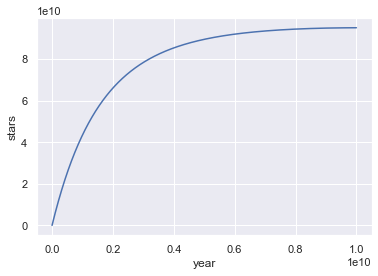

In [7]:
# plot of number of 2nd+ gen stars by year

starplot = [[0, 0]]  # year, stars

for n in range(MODERN_ERA // YEAR_STEPS):
    temp_year = starplot[-1][0]
    temp_stars = starplot[-1][1]
    temp_stars += star_formation(temp_year, temp_stars)
    starplot.append([(n+1)*YEAR_STEPS, temp_stars])

starplot = pd.DataFrame(starplot, columns=['year', 'stars'])

sns.lineplot(x=starplot.year, y=starplot.stars);

##### PLANET FORMATION

In [8]:
# number of new planets
def new_planets(num_new_stars):
    """
    New stars create new planets. These planets are not habitable yet, but 
    they only count if they will become habitable, and will develop life.
    
    Incorporates all of the following Drake parameters:
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    """
    return num_new_stars * FP * NE * FL
    

In [9]:
# number of new planets
def new_habitable(num_planets, num_habitable_planets):
    """
    the number of planets that become habitable
    doesn't track planets, just uses ratios to approximate
    """
    uninhabited = num_planets - num_habitable_planets
    newly_habitable = uninhabited * YEAR_STEPS / YEARS_PLANETS_TO_HABITABLE
    return newly_habitable
    

##### LIFE FORMATION

The following parameters are treated as timeframes instead of ratios:

    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    
These calculations just input expected value with no randomness. Monte Carlo simulation may give better insights.

In [10]:
# probability calcs whether something happens over a period
def prob_poisson(avg_time_to_happen, how_many_years_happened):
    """
    use poisson probably
    returns a ratio between 0 and 1
    results work for better known calcs, but fall apart for L
    probability of L is calculated in prob_L()
    """
    return 1 - poisson.cdf(k=1, mu=how_many_years_happened/avg_time_to_happen)


In [11]:
# need a different probability distribution for L; if L may be between 
# hundreds and millions of years, 0.0000000000000000% is not realistic 
# for 1M yr survival. Weibull distributions are simple and easy to tune:
# https://en.wikipedia.org/wiki/Weibull_distribution

def prob_L(how_many_years_happened):
    """
    probability of technological life being extinct after how_many_years_happened
    weibull distribution
    constants from the CONSTANTS section above
    """
    
    return 1 - exp(-(how_many_years_happened/WEIBULL_SCALE_PARAMETER)**WEIBULL_SHAPE_PARAMETER)
    

In [12]:
def transition(num_from, num_to, prob_of_transition):
    """
    the number of previous stage that develop into new stage
        eg, the number of habitable planets that evolve life
    doesn't track planets, just uses ratios to approximate expectations
    subtracts already transitioned life-stages
    doesn't apply to technological species - treated differently
    """
    return (num_from - num_to) * prob_poisson(prob_of_transition, YEAR_STEPS)
    

In [13]:
def new_technological(num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    """
    
    return num_cultural_life * prob_poisson(YEARS_CULTURE_TO_TECH, YEAR_STEPS)

##### EXTINCTION

In [14]:
def new_extinctions(num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N):
    """
    returns number of extinctions
    uses estimates for extinction events to subtract lifeforms
    should balance with star death
    """
    # base extinction rate from star death (RS and star death balance)
    base = RS * YEAR_STEPS / (num_stars + 1)  # stars plus 1 to eliminate div/0 error
    
    # specific extinction numbers
    extinction_simple = num_life * base
    extinction_complex = num_complex_life * (base + prob_poisson(EXTINCTION_COMPLEX, YEAR_STEPS))
    extinction_intelligent = num_intelligent_life * (base + prob_poisson(EXTINCTION_INTELLIGENT, YEAR_STEPS))
    extinction_cultural = num_cultural_life * (base + prob_poisson(EXTINCTION_CULTURAL, YEAR_STEPS))
    extinction_technological = N * prob_L(YEAR_STEPS)
    
    return extinction_simple, extinction_complex, extinction_intelligent, extinction_cultural, extinction_technological

### The Time-Dependent Drake Equation

In [15]:
def TimeDependentDrake(output_year, P_tech_dominance, df_input="empty"):
    """
    output_year is the years since 2nd gen stars, 10B ~ now
    P_tech_dominance is the proportion of intelligent lifeforms that go extinct when technological life emerges
        P_tech_dominance = 1 assumes that only one intelligent lifeform can exist once a species gains technology
    outputs the number of instances of each category active during a time step (ie, over 1M years)
    NOTE: I would be surprised if df_input="empty" is not bad form, but I'm not sure how to do this...
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += YEAR_STEPS
        num_new_stars = star_formation(current_year, num_stars)
        
        # functions - reverse order so that growth is based of previous generation
        
        # number of extinctions
        extinctions = new_extinctions(num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= extinctions[0]
        num_complex_life -= extinctions[1]
        num_intelligent_life -= extinctions[2]
        num_cultural_life -= extinctions[3]
        N -= extinctions[4]
        N_extinct += extinctions[4]  # track technological extinctions
        
        # number of technological species
        new_tech_life = new_technological(num_cultural_life, N)
        N += new_tech_life
        
        # number of cultural civilizations
        num_cultural_life += transition(num_intelligent_life, num_cultural_life, YEARS_INTELLIGENCE_TO_CULTURE)  
        # assumes only (1 - P_tech_dominance) cultural civilizations once one civilization gains tech
        # equivalent to neandrethal going extinct before we gain technology (probably because of us)
        num_cultural_life -= new_tech_life * P_tech_dominance
        
        # number of intelligent life
        num_intelligent_life += transition(num_complex_life, num_intelligent_life, YEARS_COMPLEX_TO_INTELLIGENCE)
        
        # number of complex lifeforms
        num_complex_life += transition(num_life, num_complex_life, YEARS_LIFE_TO_COMPLEX_LIFE)

        # number of simple lifeforms
        num_life += transition(num_habitable_planets, num_life, YEARS_HABITABLE_TO_LIFE)
    
        # number of habitable planets
        num_habitable_planets += new_habitable(num_planets, num_habitable_planets)
        
        # number of planets
        num_planets += new_planets(num_new_stars)
        
        # number of stars
        num_stars += num_new_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    return history_of_life
    

In [16]:
%%time
history_of_life = TimeDependentDrake(output_year=10_000_000_000, P_tech_dominance=0.9)

history_of_life.tail()

Wall time: 17.2 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9996000000,"95,039,003,081","38,015,601,233","36,963,131,775","111,602,709","196,249","5,867",8,6,"11,435"
9997000000,"95,039,102,301","38,015,640,921","36,963,658,010","111,618,774","196,301","5,870",8,6,"11,440"
9998000000,"95,039,201,519","38,015,680,608","36,964,184,001","111,634,839","196,352","5,872",8,6,"11,446"
9999000000,"95,039,300,735","38,015,720,294","36,964,709,749","111,650,903","196,404","5,874",8,6,"11,451"
10000000000,"95,039,399,949","38,015,759,980","36,965,235,255","111,666,968","196,455","5,876",8,6,"11,457"


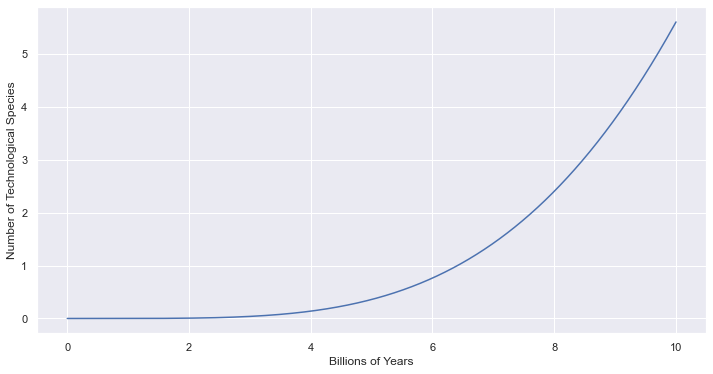

In [17]:
# plot of technological species over time

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000_000, y=history_of_life.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# How to interpret these averages/expectations given 1M yr time steps

These numbers are based on the active instances over 1M year time steps. This isn't significant for values with slower
extinction values, but with N, these predictions are misleading. E.g., 100 technological species seems like
a lot, but if that's over 1M years, and they each survive 1k yr, there is less than 1 on average at the same time.

We need to convert these numbers into probabilities / histograms to gain insight into how likely we are to find life. 

In [18]:
#TODO set up a monte carlo for this calc, it has a reasonable amount of variance

In [19]:
# number of technological lifeforms in 1M yr timestep at end of Drake calculation
N_1M_yr = int(round(history_of_life.iloc[[-1]].N))

def breakdown_by_year(N_1M_yr):
    """
    input number active over YEAR_STEPS (eg, 1M years)
    simulate number active at any given point in time
    uses random numbers, same Weibull coefficients as CONSTANTS section
    """
    # initialise 1M years all with 0s
    active_each_year = pd.DataFrame(np.zeros((YEAR_STEPS, 1)))

    # loop trough each year and add N_1M_yr lifeforms, each with a random Weibull lifespan
    for n in range(N_1M_yr):
        # random species characteristics
        year_birth = int(np.random.randint(0, YEAR_STEPS-1))
        year_death = int(year_birth + np.random.weibull(WEIBULL_SHAPE_PARAMETER) * WEIBULL_SCALE_PARAMETER)
        
        if year_death < YEAR_STEPS:
            active_each_year.iloc[year_birth:year_death] += 1
        else:
            active_each_year.iloc[year_birth:YEAR_STEPS] += 1
            year_death = min(year_death - YEAR_STEPS, year_birth)
            active_each_year.iloc[0:year_death] += 1
        
    return active_each_year


In [20]:
def percentage_table(active_each_year_dataframe):
    N_active = active_each_year_dataframe.value_counts().astype('float')
    N_active_percent = (N_active / 10000).sort_index()
    print(N_active_percent.map('{:,.2f}%'.format))

In [98]:
def plot_histogram(active_each_year_dataframe, binwidth=1, **kwargs):
    # histogram of active technological civilizations
    plt.figure(figsize=(16, 8))
    plot = sns.histplot(active_each_year_dataframe, legend=False, binwidth=binwidth, **kwargs);
    plot.set_ylabel('Count');
    plot.set_xlabel('Number of Active Technological Species');
    plot.xaxis.set_major_locator(MaxNLocator(integer=True));
    
    # https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
    # could format axis to be percentages

In [22]:
# number of technological lifeforms in 1M yr timestep at end of Drake calculation
N_1M_yr = int(round(history_of_life.iloc[[-1]].N))
N_1M_yr

6

In [23]:
%%time

active_each_year = breakdown_by_year(N_1M_yr)

Wall time: 6.98 ms


In [24]:
percentage_table(active_each_year)

0    57.40%
1    42.12%
2     0.48%
dtype: object


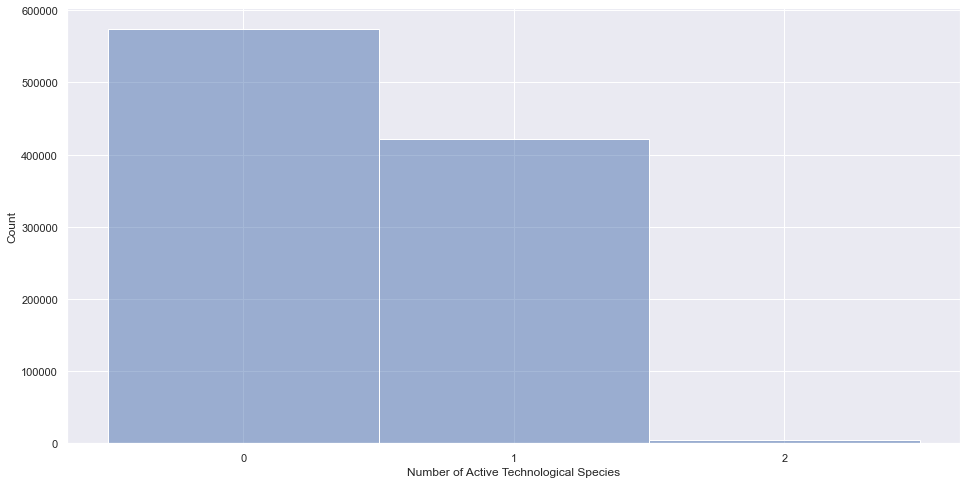

In [99]:
plot_histogram(active_each_year, discrete=True)

In [28]:
%%time
# hypothetical large number of technological lifeforms active in 1M yr timestep

# TESTING
N_large = 1_000
# histogram starts getting messy at 1k+, can't bin it easily because it's actually a barplot

active_each_year_large = breakdown_by_year(N_large)

Wall time: 419 ms


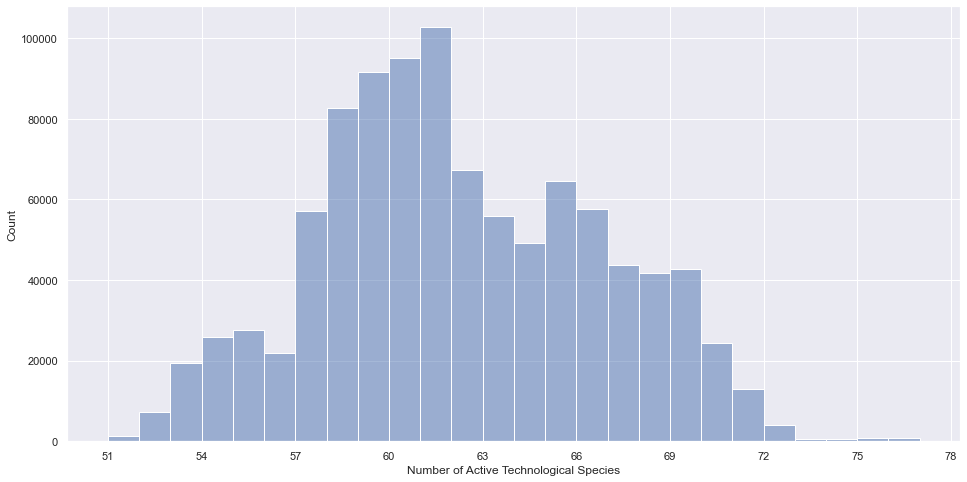

In [100]:
plot_histogram(active_each_year_large)

# implications of tech_dominance

In [30]:
%%time
tech_dominance_1 = TimeDependentDrake(output_year=10_000_000_000, P_tech_dominance=1)

tech_dominance_1.tail()

Wall time: 15.8 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9996000000,"95,039,003,081","38,015,601,233","36,963,131,775","111,602,709","196,249","5,867",7,5,"10,604"
9997000000,"95,039,102,301","38,015,640,921","36,963,658,010","111,618,774","196,301","5,870",7,5,"10,609"
9998000000,"95,039,201,519","38,015,680,608","36,964,184,001","111,634,839","196,352","5,872",7,5,"10,614"
9999000000,"95,039,300,735","38,015,720,294","36,964,709,749","111,650,903","196,404","5,874",7,5,"10,619"
10000000000,"95,039,399,949","38,015,759,980","36,965,235,255","111,666,968","196,455","5,876",7,5,"10,624"


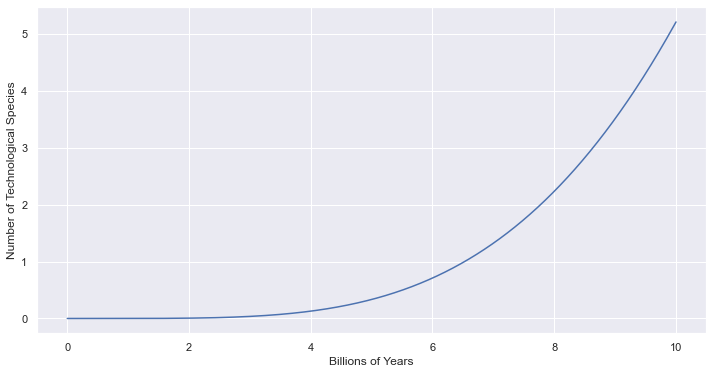

In [31]:
plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=tech_dominance_1.index/1_000_000_000, y=tech_dominance_1.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

In [32]:
%%time
tech_dominance_0 = TimeDependentDrake(output_year=10_000_000_000, P_tech_dominance=0)

tech_dominance_0.tail()

Wall time: 16.1 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9996000000,"95,039,003,081","38,015,601,233","36,963,131,775","111,602,709","196,249","5,867",27,19,"38,786"
9997000000,"95,039,102,301","38,015,640,921","36,963,658,010","111,618,774","196,301","5,870",27,19,"38,805"
9998000000,"95,039,201,519","38,015,680,608","36,964,184,001","111,634,839","196,352","5,872",27,19,"38,823"
9999000000,"95,039,300,735","38,015,720,294","36,964,709,749","111,650,903","196,404","5,874",27,19,"38,842"
10000000000,"95,039,399,949","38,015,759,980","36,965,235,255","111,666,968","196,455","5,876",27,19,"38,861"


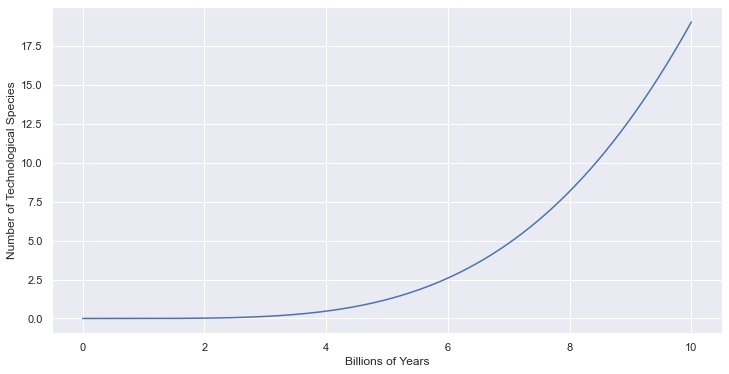

In [33]:
plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=tech_dominance_0.index/1_000_000_000, y=tech_dominance_0.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# implications of longer time values (eg, 1T yr, steady state, etc)

In [ ]:
#TODO: write a loop to save csv in 10B yr increments
# combine csv
    # eg, history_of_life.to_csv('history_of_life_1T_yr.csv')  # or nested path
# plot it

In [45]:
%%time

epoch_steps = 1_000_000_000
final_year = 100_000_000_000
n_epoch = final_year // epoch_steps
P_tech_dominance = 0.9

index = 'year'
columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
       'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']

future_of_life = pd.DataFrame(
    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
    columns = columns,
    index=[0]
).set_index(index)

for i in range(n_epoch):
    temp_df = TimeDependentDrake(epoch_steps*(1+i), P_tech_dominance, df_input=future_of_life)
    future_of_life = future_of_life.append(temp_df.iloc[[-1]])


Wall time: 2min 4s


In [46]:
# for 10B yr: 12s 
# for 100B yr: 124s
# for 1T yr: estimate 1240s = 21min
future_of_life.tail()

,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
96000000000,"99,111,739,736","39,644,695,894","39,629,891,557","802,761,174","12,741,157","2,609,026","3,503","2,494","82,307,792"
97000000000,"99,129,328,642","39,651,731,457","39,637,220,267","805,933,111","12,876,605","2,650,026","3,558","2,533","84,800,129"
98000000000,"99,146,569,260","39,658,627,704","39,644,403,859","809,046,554","13,010,863","2,690,870","3,613","2,572","87,331,256"
99000000000,"99,163,468,489","39,665,387,395","39,651,445,204","812,102,595","13,143,928","2,731,551","3,667","2,611","89,901,022"
100000000000,"99,180,033,086","39,672,013,235","39,658,347,119","815,102,304","13,275,796","2,772,062","3,722","2,650","92,509,268"


# steady state values from first principals
    when will we reach approx steady state?
    what are steady state values?
    can we match the time-invariant Drake Equation?

In [71]:
%%time
steady_state = pd.DataFrame(
    [[0, 100_000_000_000, 40_000_000_000, 40_000_000_000, 974_950_000, 23_000_000, 6_000_000, 8_000, 6_000, 0]], 
    columns = columns,
    index=[0]
).set_index(index)

for i in range(5):
    temp_df = TimeDependentDrake(10_000_000_000*(i+1), P_tech_dominance, df_input=steady_state)
    steady_state = steady_state.append(temp_df.iloc[[-1]])
    
steady_state.tail()

Wall time: 1min 6s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
10000000000,100_000_000_000,40_000_000_000,40_000_000_000,974_954_804,23_115_443,6_143_690,8_248,5_873,57_592_102
20000000000,100_000_000_000,40_000_000_000,40_000_000_000,974_958_717,23_209_390,6_245_776,8_386,5_970,116_336_288
30000000000,100_000_000_000,40_000_000_000,40_000_000_000,974_961_905,23_285_844,6_319_379,8_484,6_041,175_904_829
40000000000,100_000_000_000,40_000_000_000,40_000_000_000,974_964_502,23_348_063,6_373_230,8_557,6_092,236_071_870
50000000000,100_000_000_000,40_000_000_000,40_000_000_000,974_966_617,23_398_697,6_413_195,8_610,6_130,296_679_794


In [92]:
def plot_histogram(active_each_year_dataframe, binwidth=1, **kwargs):
    # histogram of active technological civilizations
    plt.figure(figsize=(16, 8))
    plot = sns.histplot(active_each_year_dataframe, legend=False, binwidth=binwidth, **kwargs);
    plot.set_ylabel('Count');
    plot.set_xlabel('Number of Active Technological Species');

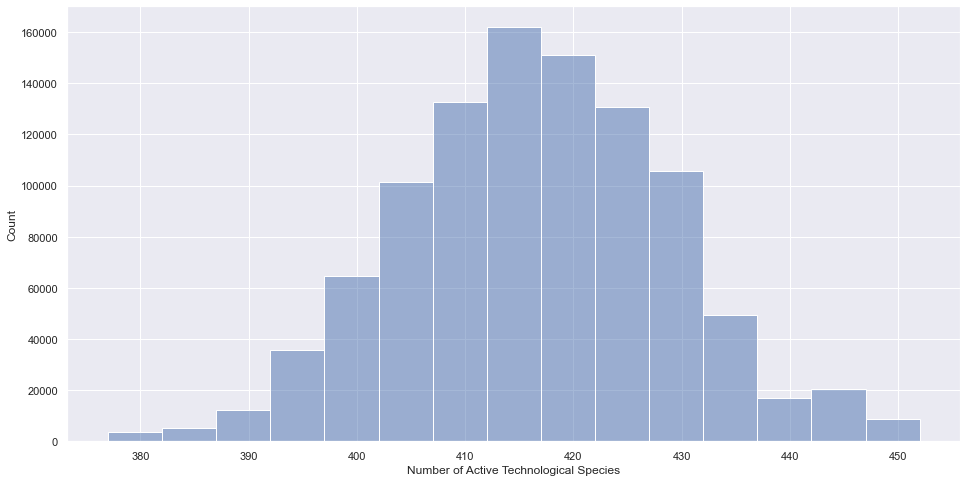

In [101]:
plot_histogram(breakdown_by_year(7_000), binwidth=5)